# Imports

In [1]:
import pandas as pd
import bz2
import json
import pickle

from extraction_helpers import *
import os


In [2]:
# filename = open("extracted_data\output_2020 speakers_False keywords_['hurricane', 'climate change'].pickle", "rb")
# df = pickle.load(filename)

In [3]:
# Load pickle file

filename = os.listdir('./extracted_data')[0]
print(filename)

filename = open("extracted_data/{}".format(filename), "rb")
dict_df = pickle.load(filename)

output_2020 speakers_False keywords_['hurricane', 'climate change'].pickle


In [ ]:
# print("Speakers : " + str(list(dict_df.keys())))
# print("Keywords : " + str(list(dict_df[list(dict_df.keys())[0]].keys())))

In [4]:
dict_df

{'hurricane':                quoteID                                          quotation  \
 1    2020-03-19-078988  We all are seeing and feeling changes we could...   
 2    2020-04-15-075762  We've lost business in our Village, but on a g...   
 3    2020-03-27-032099  It's busy, but it's not as busy as we've seen ...   
 4    2020-02-12-088622  The Maurepas Swamp is not just an amazing and ...   
 5    2020-01-24-106321  We're currently building a similar house about...   
 ..                 ...                                                ...   
 832  2020-03-25-057906  So, the storm is coming. Mr. President, please...   
 833  2020-03-05-061833  The bulk of revenue comes in by the time we ge...   
 834  2020-02-04-100434  We are exposed -- there's no question about it...   
 835  2020-02-26-010118  but we've seen some of the hurricane-resistant...   
 836  2020-03-20-004358  And the boat's been in beautiful waters. But n...   
 
                    speaker                    qi

# Treat data

In [5]:
# In each date, remove the info about hours, minutes and seconds
# This facilitates aggregating data for each day

for keyword in dict_df:
    for index, row in dict_df[keyword].iterrows():
        dict_df[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


C:\Users\clnma\AppData\Local\Temp/ipykernel_21080/1242928348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df[keyword]['date'][index] = pd.to_datetime(str(row['date'])[:10])


In [6]:
# Sort the values in ascending chronological order

for keyword in dict_df:
    dict_df[keyword] = dict_df[keyword].sort_values('date', ascending=True)


In [7]:
dict_count_occurences = {}
for keyword in dict_df:
    dict_count_occurences[keyword] = dict_df[keyword]['date'].value_counts(sort=False)

# Plots

In [8]:
hurr = dict_count_occurences['hurricane'].rolling(14).sum()
clim = dict_count_occurences['climate change'].rolling(14).sum()

hurr.corr(clim)

-0.8460630937473785

In [ ]:
hurr_add = hurr + pd.Series([0,0,0,0,0,0,0])

In [ ]:
dict_count_occurences['hurricane']

In [ ]:
L_climate = []
L_hurricane = []

for date in dict_count_occurences['climate change'].keys():
    

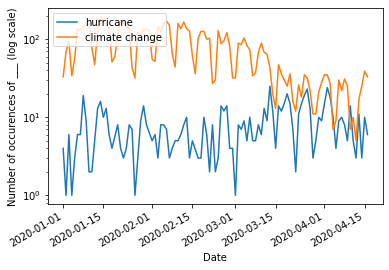

In [11]:
for keyword in dict_df:
    ax = dict_count_occurences[keyword].plot(logy = True)
ax.set_xlabel("Date")
ax.set_ylabel("Number of occurences of ___ (log scale)")
ax.legend([keyword for keyword in dict_df], loc = 'upper left')

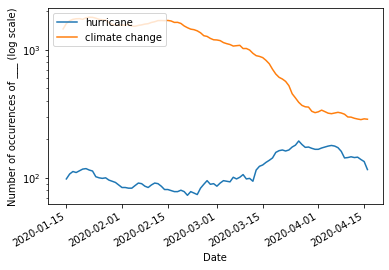

In [12]:
for keyword in dict_df:
    ax_roll = dict_count_occurences[keyword].rolling(14).sum().plot(logy = True)
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Number of occurences of ___ (log scale)")
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

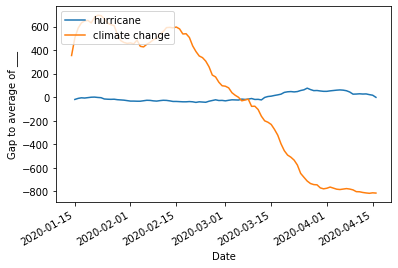

In [13]:
for keyword in dict_df:
    ax_roll = (dict_count_occurences[keyword].rolling(14).sum() - dict_count_occurences[keyword].rolling(14).sum().mean()).plot()
ax_roll.set_xlabel("Date")
ax_roll.set_ylabel("Gap to average of ___")
# ax_roll.set_ylim([300, 1500])
ax_roll.legend([keyword for keyword in dict_df], loc = 'upper left')

In [14]:
from statsmodels.tsa.stattools import ccf

In [ ]:
ccf(hurr_add, clim)